# Adaptive buffer as an additional tessellation limit

The original morphological tessellation paper and applications in subsequent papers were using a fixed buffer around buildings as an external limit for generation of tessellation. This distance was derived from the Fleischmann et al. (2020) paper. However, the consequence of that is that tessellation cells on the edges of settlements were usually much larger than their immediate neighbors. During the clustering step, this occasionally resulted it clusters that could be interpreted as "edge tissue". We have effectively seen an edge effect here. Similar issue was present in enclosed tessellation, where edge cells fill all of the enclosure, which may be even larger than 100m buffer.

This notebook illustrates another approach to the problem. It uses enclosed tessellation as the partitioning method but includes the buffer around buildings as another set of limits with the idea, that only cells with buildings will be considered in the analysis. Unlike spatial signatures, our classificaiton will focus on form only, hence it needs to, optimally, be directly attached to buildings. Moreover, the buffer is not using a fixed distance but is adaptive to the context of each building.

In [11]:
import geopandas
import libpysal
import momepy
import numpy as np
from libpysal.graph import Graph

libpysal.__version__, momepy.__version__, geopandas.__version__

('4.11.dev16+ge9eed186',
 '0.7.1.dev33+g8e93b6c.d20240520',
 '1.0.0-alpha1+39.ge829498')

Let's use the built-in data in momepy as an illustration.

In [2]:
buildings = geopandas.read_file(momepy.datasets.get_path("bubenec"), layer='buildings')
buildings.head()

,uID,geometry
0,1,"POLYGON ((1603599.221 6464369.816, 1603602.984..."
1,2,"POLYGON ((1603042.88 6464261.498, 1603038.961 ..."
2,3,"POLYGON ((1603044.65 6464178.035, 1603049.192 ..."
3,4,"POLYGON ((1603036.557 6464141.467, 1603036.969..."
4,5,"POLYGON ((1603082.387 6464142.022, 1603081.574..."


## Gabriel graph

The idea behind the adaptive buffer is that buildings that are densely packed together have smaller tessellation cells while those in the sparser areas, have larger cells. We can therefore derive the buffer distance based on the inter-building distance. Without underlying contiguous unit, we can derive neighbors using Delaunay triangulation (note that we need to represent buildings as points - centroids). That would look like this:

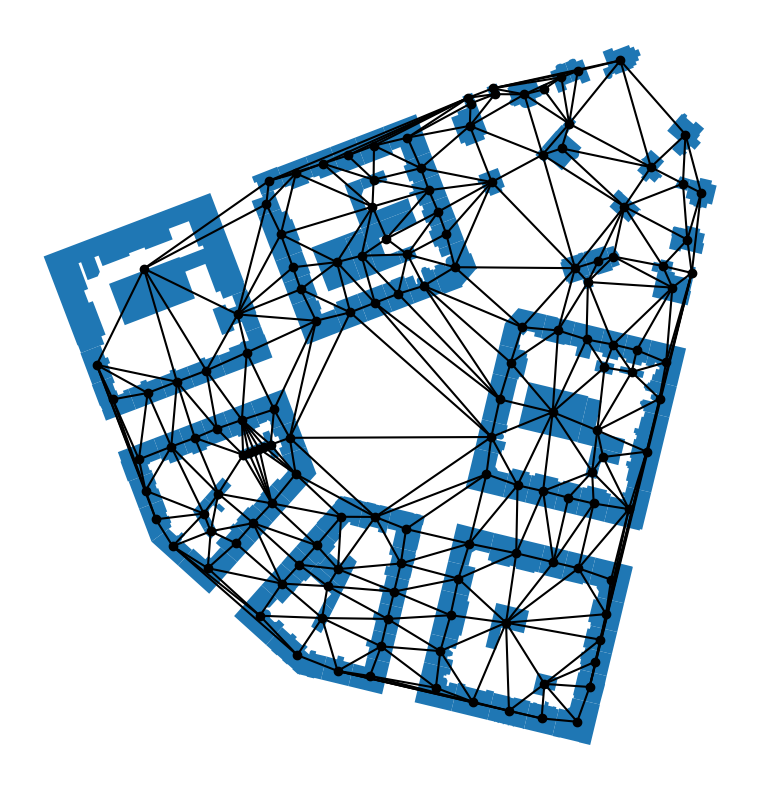

In [3]:
delaunay = Graph.build_triangulation(buildings.centroid, "delaunay", kernel="identity")
ax = buildings.plot(figsize=(10, 10))
delaunay.plot(buildings, ax=ax).set_axis_off()

While this approach conceptually works, there are some connections along the edges and across large open spaces that are not reflecting the concept of neighbors in the morphological sense.

We can therefore use a subset of Delaunay triangulation called [Gabriel graph](https://en.wikipedia.org/wiki/Gabriel_graph) that filters out all edges which minimum enclosing circle would contain any other node. This effectively removes those edges we find problematic.

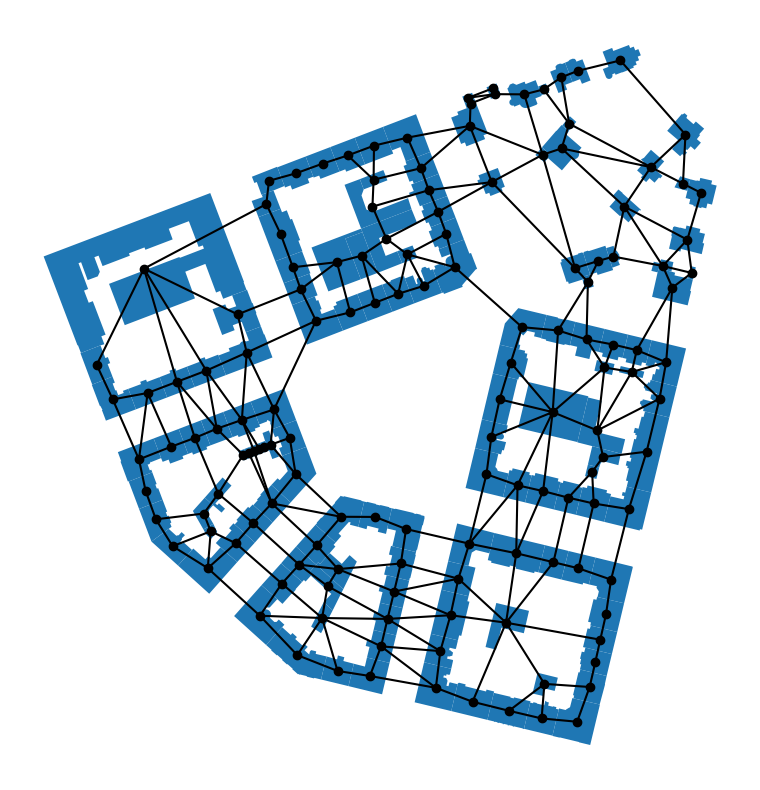

In [4]:
gabriel = Graph.build_triangulation(buildings.centroid, "gabriel", kernel="identity")
ax = buildings.plot(figsize=(10, 10))
gabriel.plot(buildings, ax=ax).set_axis_off()

From the Gabriel graph, we can derive the maximum distance to each neighbor.

In [5]:
max_dist = gabriel.aggregate("max")

And use is to derive the buffering distance as half of the maximum distance + 10% of the maximum distance to ensure two buildings across each other cover the area in beween of them by a combination of their buffers.

In [6]:
buff = buildings.buffer(np.clip(max_dist / 2 + max_dist *.1, 0, 100).values, resolution=4)

The union of such buffers can then be used as a limit of tessellation. This applies both to morphological and enclosed tessellation.

In [7]:
union = buff.union_all()

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_80708/2862513479.py:1: FutureWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union = buff.unary_union


## Example of usage

See it in practice

### Enclosed tessellation

In [8]:
streets = geopandas.read_file(momepy.datasets.get_path("bubenec"), layer='streets')

Generate enclosures using the new boundary as both limit and barriers.

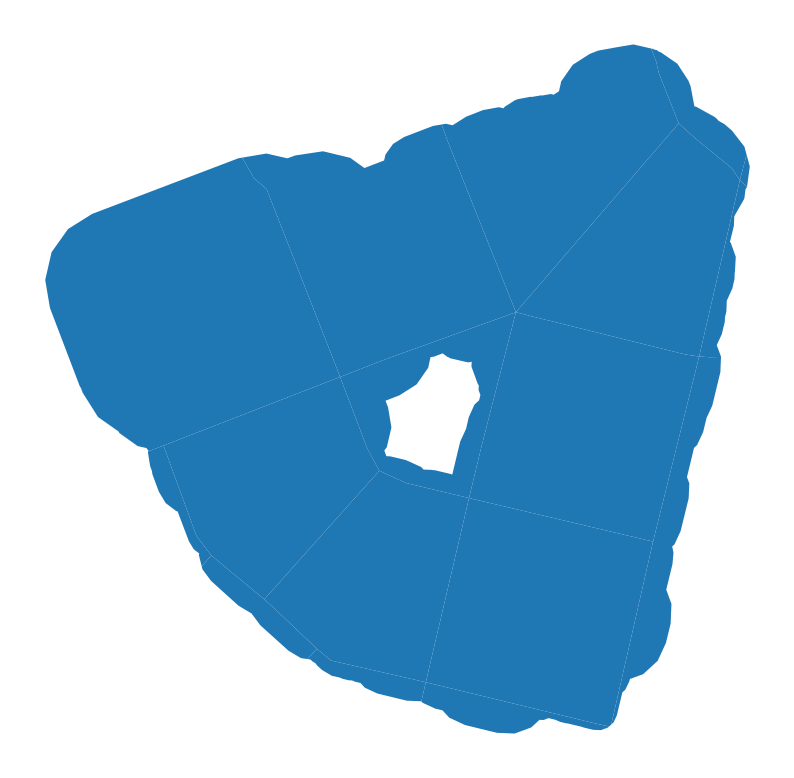

In [9]:
enclosures = momepy.enclosures(streets, limit=union, additional_barriers=[geopandas.GeoSeries(union.boundary.geoms, crs=streets.crs)], clip=True)
enclosures.plot(figsize=(10, 10)).set_axis_off()

Generate tessellation.

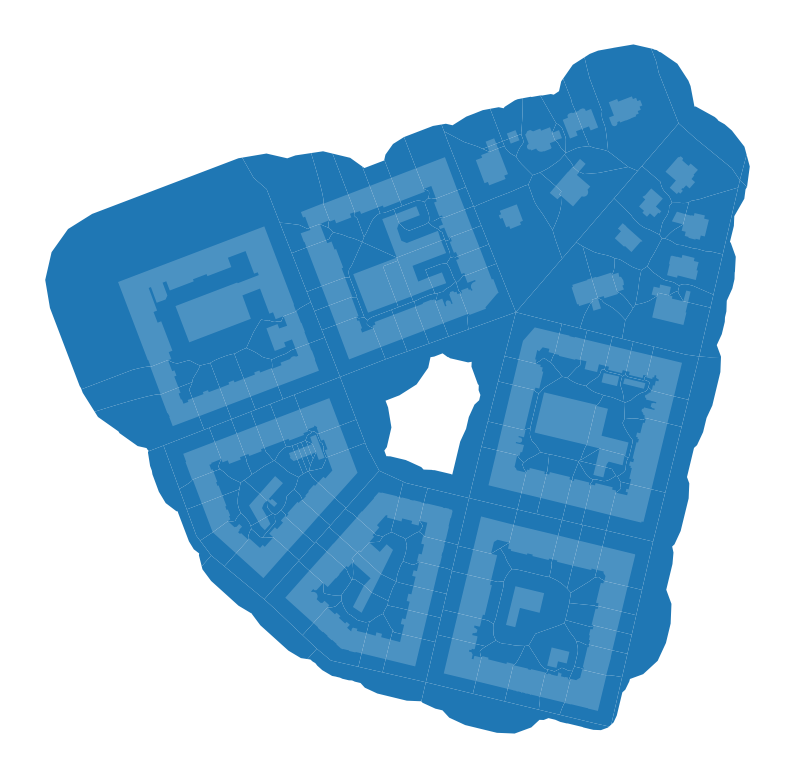

In [15]:
tess = momepy.enclosed_tessellation(buildings, enclosures.geometry)
ax = tess.plot(figsize=(10, 10))
buildings.plot(ax=ax, color="w", alpha=.2).set_axis_off()

### Morphological tessellation

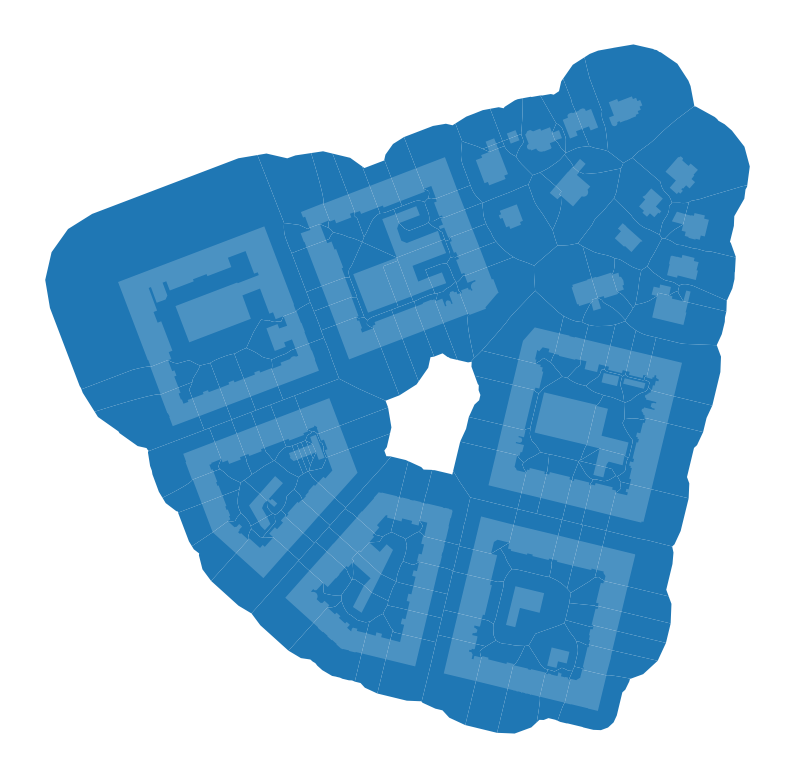

In [16]:
mtess = momepy.morphological_tessellation(buildings, union)
ax = mtess.plot(figsize=(10, 10))
buildings.plot(ax=ax, color="w", alpha=.2).set_axis_off()

Compared to the stardard approach:

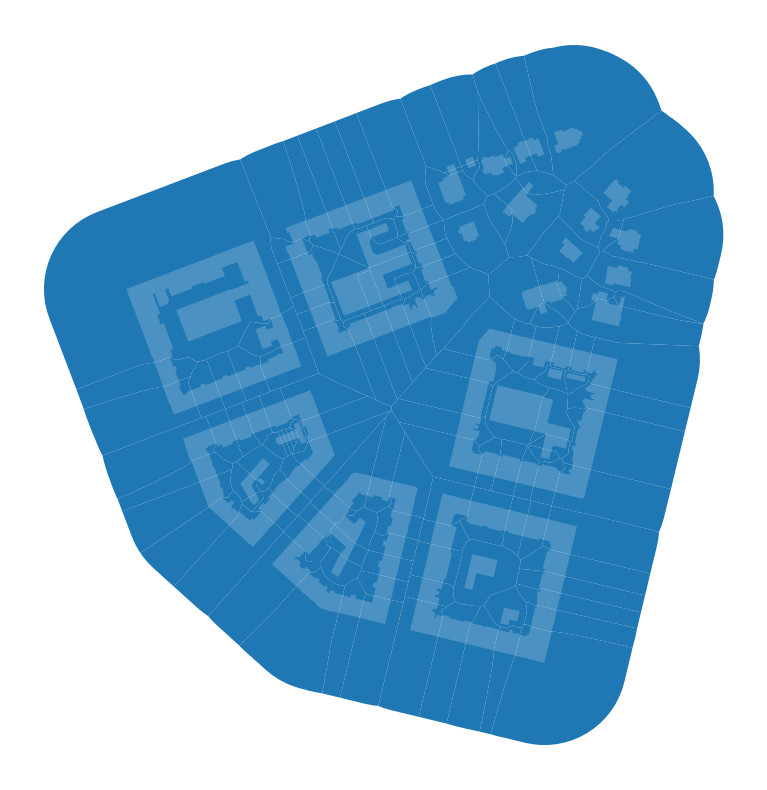

In [18]:
mtess = momepy.morphological_tessellation(buildings, momepy.buffered_limit(buildings, 100))
ax = mtess.plot(figsize=(10, 10))
buildings.plot(ax=ax, color="w", alpha=.2).set_axis_off()

## Limits

The distance is derived from centroids, hence it may be too large for areas with large buildings. But using polygon-to-polygon distance results in some 0.

Note that this may result in more MultiPolygons in the enclosed tessellation output (due to more boundaries). Ensure you do a proper treatment of the result before proceeding to the analysis.